# Seleciona autores para dataset

- Divide as obras dos autores em "chunks" de 600 notas.
- Autores que totalizam mais de 200 chunks foram filtrados.
- Destes, 5 foram selecionados por relevância pelo autor.
- O método de validação é 10-fold cross validation.

In [1]:
# Get all authors
import mido
import numpy as np
from pathlib import Path

NOTE_MAX = 119.0

def create_chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    ch = []
    for i in range(0, len(lst), n):
        chunk_slice = lst[i:i + n]
        if len(chunk_slice) == n:
            ch.append(np.array(chunk_slice))
    return ch

def track_to_chunks(track, chunk_size=600):
    notes = [
        -msg.note / NOTE_MAX
        for msg in track
        if msg.type == "note_on"
    ]
    
    return create_chunks(notes, chunk_size)
    
def read_midi_chunks(file_path):
    mid = mido.MidiFile(file_path)
    
    return [
        chunk
        for track in mid.tracks
        for chunk in track_to_chunks(track)
    ]

# Selected authors with more than 200 tracks
author_list = [
    "Chopin Frédéric",
    "Albéniz Isaac",
    "Beethoven Ludwig van",
    "Bach Carl Philipp Emanuel",
    "Haydn Joseph"
    
]

author_chunks = dict()

for file_path in Path("./full-dataset").glob("*.mid"):
    name, surname, *_ = file_path.stem.split(",")
    full_name = name + surname
    
    if full_name in author_list:
        chunks = read_midi_chunks(file_path)
        if full_name in author_chunks:
            author_chunks[full_name].extend(chunks)
        else:
            author_chunks[full_name] = chunks

for author in author_chunks:
    author_chunks[author] = np.array(author_chunks[author])

# Cria funções de plot

In [2]:
from matplotlib import pyplot as plt

def plot_loss(history):
    val_loss = history.history["val_loss"]
    loss = history.history["loss"]

    plt.title("Perda e Perda de Validação")
    plt.plot(loss, "b", val_loss, "r")

def plot_accuracy(history):
    val_acc = history.history["val_accuracy"]
    acc = history.history["accuracy"]
    
    plt.title("Acurácia e Acurácia de Validação")
    plt.plot(acc, "b", val_acc, "g")
    

# Cria Modelo

O modelo consiste em uma rede CNN com ativações *relu* nas camadas intermediárias e *softmax* na camada de saída, usando *Adam* como algorítmo de treinamento, função de loss *categorial crossentropy* e métrica de acurácia.

Running fold no 0
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 600, 1)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 593, 8)            72        
_________________________________________________________________
average_pooling1d (AveragePo (None, 295, 8)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 288, 8)            520       
_________________________________________________________________
average_pooling1d_1 (Average (None, 143, 8)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 128, 16)           2064      
_________________________________________________________________
average_pooling1d_2 (Average (None, 

5/5 [==============================] - 1s 196ms/step - loss: 1.4389 - accuracy: 0.3718 - val_loss: 1.4256 - val_accuracy: 0.3820
Epoch 49/50
5/5 [==============================] - 1s 167ms/step - loss: 1.4172 - accuracy: 0.3863 - val_loss: 1.4257 - val_accuracy: 0.3820
Epoch 50/50
5/5 [==============================] - 1s 172ms/step - loss: 1.4258 - accuracy: 0.3783 - val_loss: 1.4256 - val_accuracy: 0.3820


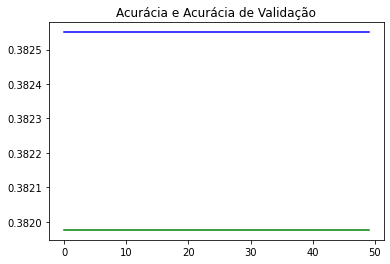

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from wandb.keras import WandbCallback

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, AveragePooling1D, MaxPooling1D, Dense, Flatten, ZeroPadding1D, Reshape, GlobalAveragePooling1D, Dropout

num_folds = 10
author_y = {
    "Chopin Frédéric": np.array([1.0, 0.0, 0.0, 0.0, 0.0]),
    "Albéniz Isaac": np.array([0.0, 1.0, 0.0, 0.0, 0.0]),
    "Beethoven Ludwig van": np.array([0.0, 0.0, 1.0, 0.0, 0.0]),
    "Bach Carl Philipp Emanuel": np.array([0.0, 0.0, 0.0, 1.0, 0.0]),
    "Haydn Joseph": np.array([0.0, 0.0, 0.0, 0.0, 1.0])
}

def get_chunks_for_fold(num_fold):
    # 0 to 0.9
    percent = num_fold / num_folds
    # 0.1 to 1.0
    next_percent = (num_fold + 1) / num_folds
    
    x_train = []
    y_train = []
    x_validation = []
    y_validation = []

    for author in author_chunks:
        chunks = author_chunks[author]
        f_idx = int(len(chunks) * percent)
        s_idx = int(len(chunks) * next_percent)
        
        x_train.extend(chunks[f_idx:s_idx])
        y_train.extend([author_y[author] for _ in range(len(chunks[f_idx:s_idx]))])
        
        x_validation.extend(chunks[s_idx:])
        y_validation.extend([author_y[author] for _ in range(len(chunks[s_idx:]))])
        x_validation.extend(chunks[:f_idx])
        y_validation.extend([author_y[author] for _ in range(len(chunks[:f_idx]))])
    
    return np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation)
            

for i in range(1):
    print(f"Running fold no {i}")
    x_train, y_train, x_validation, y_validation = get_chunks_for_fold(i)
    
    model = Sequential([
        Reshape((600, 1), input_shape=(600, )),
        Conv1D(8, 8, activation="relu", input_shape=((600, 1))),
        AveragePooling1D(pool_size=4, strides=2),
        Conv1D(8, 8, activation="relu"),
        AveragePooling1D(pool_size=4, strides=2),
        Conv1D(16, 16, activation="relu"),
        AveragePooling1D(pool_size=4, strides=2),
        LSTM(6),
        Dense(5, activation="softmax")
    ])
    model.summary()
    opt = keras.optimizers.Adam(learning_rate=0.0004)
    
    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_validation, y_validation),
        epochs=50,
        batch_size=128
    )
    
#     plot_loss(history)
    plot_accuracy(history)


# Organize Dataset

In [32]:
import glob
import mido

def get_message_value(msg):
    if msg.type == "note_on" and msg.velocity != 0:
        return -msg.note / NOTE_MAX

def track_to_notes(track):
    notes = [m for m in track if m.type.startswith("note_")]
    if len(notes) == 0:
        return []
    
    val = get_message_value(notes[0])
    out = []
    
    for m in notes:
        out.append(get_message_value(m) - val)
        val = get_message_value(m)
    return out

def get_author_tracks(author):
    tracks = []
    for dr in glob.glob("dataset/" + author + "/**"):
        mid = mido.MidiFile(dr)
        tracks.extend(mid.tracks)
    return tracks

def get_author_note_list(author, min_note_count=600):
    tracks = get_author_tracks(author)
    note_list = [track_to_notes(t) for t in tracks]
    return [n for n in note_list if len(n) >= min_note_count]

def get_author_min_note_list(note_lists):
    lens = [len(t) for t in note_lists]
    return min(lens)

def divide_note_list_into_inputs(note_list, group_size=600):
    chunks = []
    chunk_size = len(note_list) // 600
    for i in range(0, chunk_size):
        chunks.append(note_list[group_size * i: group_size * (i + 1)])
    return chunks

def get_tracks_chunks(tracks):
    chunks = []
    for t in tracks:
        chunks.extend(divide_note_list_into_inputs(t))
    
    return chunks

albeniz_tracks = get_author_note_list("Albéniz Isaac")
agnew_tracks = get_author_note_list("Agnew Roy")
behr_tracks = get_author_note_list("Behr Franz")
liszt_tracks = get_author_note_list("Liszt Franz")
zierau_tracks = get_author_note_list("Zierau Fritz")
frontini_tracks = get_author_note_list("Frontini Francesco Paolo")

albeniz_chunks = get_tracks_chunks(albeniz_tracks)
agnew_chunks = get_tracks_chunks(agnew_tracks)
behr_chunks = get_tracks_chunks(behr_tracks)
liszt_chunks = get_tracks_chunks(liszt_tracks)
zierau_chunks = get_tracks_chunks(zierau_tracks)
frontini_chunks = get_tracks_chunks(frontini_tracks)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

# Cross Validation

In [72]:
import math

# K-Fold cross validation where K = 10
def get_folds(all_authors, folds = 10):
    for author in all_authors:
        print(len(author))
        partition = int(math.ceil(1.0 * len(author) * (1.0 / folds)))
        # print(partition)
        
    return []
    


folds = get_folds([albeniz_chunks, agnew_chunks, behr_chunks, liszt_chunks, zierau_chunks, frontini_chunks])

234
10
29
221
17
24


# Define Dataset

In [33]:
def halve_array(arr):
    div = len(arr) // 2
    return arr[:div], arr[div:]

def create_labels(label, leng):
    labels = []
    for _ in range(leng):
        labels.append(label)
    return labels

def generate_data_from_chunks(chunks, label):
    train, test = halve_array(chunks)
    train_labels = create_labels(label, len(train))
    test_labels = create_labels(label, len(test))

    return {
        "train_data": train,
        "test_data": test,
        "train_labels": train_labels,
        "test_labels": test_labels
    }

def train_data_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["train_data"] + d["test_data"]
    return np.array(data)

def train_labels_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["train_labels"] + d["test_labels"]
    return np.array(data)

input_dim = len(albeniz_chunks[0])
print(input_dim)
def test_data_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["test_data"]
    return np.array(data)

def test_labels_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["test_labels"]
    return np.array(data)

input_dim = len(albeniz_chunks[0])

albeniz_dataset = generate_data_from_chunks(albeniz_chunks, [1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
behr_dataset = generate_data_from_chunks(behr_chunks, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
frontini_dataset = generate_data_from_chunks(frontini_chunks, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
liszt_dataset = generate_data_from_chunks(liszt_chunks, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
zierau_dataset = generate_data_from_chunks(zierau_chunks, [0.0, 0.0, 0.0, 0.0, 1.0, 0.0])
agnew_dataset = generate_data_from_chunks(agnew_chunks, [0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
datasets = [albeniz_dataset, behr_dataset, frontini_dataset, liszt_dataset, zierau_dataset, agnew_dataset]

train_data = train_data_from_datasets(datasets)
train_labels = train_labels_from_datasets(datasets)

final_train, final_labels = shuffle(train_data, train_labels)

NameError: name 'albeniz_chunks' is not defined

# Run Model

In [54]:


history = model.fit(
    final_train,
    final_labels,
    validation_split=0.3,
    epochs=40,
    verbose=0
)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 600, 1)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 551, 30)           1530      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 549, 50)           4550      
_________________________________________________________________
global_average_pooling1d_12  (None, 50)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 306       
Total params: 6,386
Trainable params: 6,386
Non-trainable params: 0
___________________________________________________

TypeError: 'NoneType' object is not subscriptable

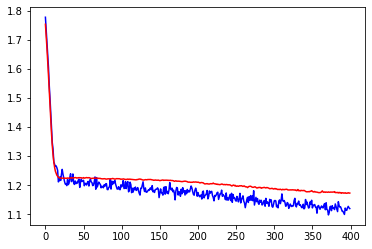

In [51]:
from matplotlib import pyplot as plt

val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
acc = history.history["accuracy"]

ax, fig = plt.plot(loss, "b", val_loss, "r")

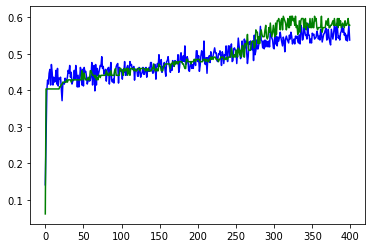

In [45]:
ax2, fig2 = plt.plot(acc, "b", val_acc, "g")

In [49]:
print(history.validation_data)

None
